In [1]:
#Import everything
import test_manifold_algorithms as tma
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from regression_helpers import *

2024-10-28 09:17:12.611597: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 09:17:12.612284: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 09:17:12.615961: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 09:17:12.661770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 09:17:14.099462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

# Baseline Visualization

In [2]:
baselines_cross = pd.read_csv("/yunity/arusty/Graph-Manifold-Alignment/RegressionData/BaselineData.csv")
baselines = pd.read_csv("/yunity/arusty/Graph-Manifold-Alignment/RegressionData/BaselineData.csv")
baselines.sample(5)

,csv_file,split,KNN,A_Classification_Score,B_Classification_Score
10,AirfoilSelfNoise,even,2,-0.381581,-0.792809
57,AutoMPG,distort,58,-0.160133,-0.134005
336,ConcreteSlumpTest,skewed,20,-0.153198,-0.193892
659,SML2010,distort,749,0.599973,0.600113
672,SML2010,random,168,-0.800488,0.172956


In [3]:
baselines_grouped = baselines.groupby(by = ["csv_file", "split"]).max().drop(columns = ["KNN"]).reset_index()
baselines_grouped

,csv_file,split,A_Classification_Score,B_Classification_Score
0,AirfoilSelfNoise,distort,0.875245,0.891830
1,AirfoilSelfNoise,even,-0.099397,-0.095991
2,AirfoilSelfNoise,random,-0.104496,-0.115598
3,AirfoilSelfNoise,skewed,-0.137537,-0.202338
4,AirfoilSelfNoise,turn,-0.354418,-0.354418
...,...,...,...,...
65,SML2010,distort,0.989443,0.988617
66,SML2010,even,-0.198643,-0.105772
67,SML2010,random,-0.250462,0.176966
68,SML2010,skewed,-0.107237,-0.034869


<Axes: xlabel='csv_file'>

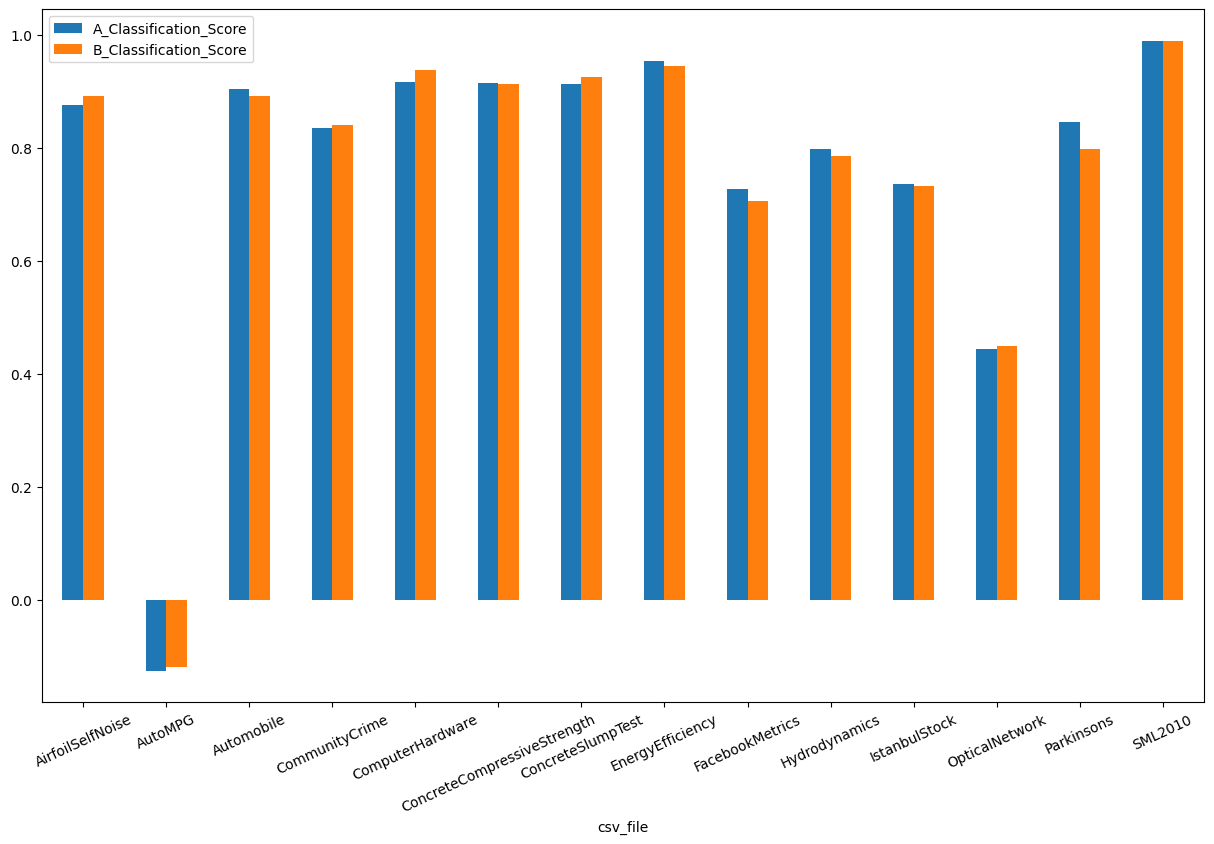

In [20]:
baselines_grouped[baselines_grouped["split"] == "distort"].set_index("csv_file").plot(kind = "bar", subplots=False, figsize=(15,9), rot= 25)
#Keep in mind that these are trained on one domain, then tested on the other. 

# Model Comparison

In [5]:
reg_df = read_json_files_to_dataframe("/yunity/arusty/Graph-Manifold-Alignment/RegressionData")
reg_df.sample(5)


,method,csv_file,split,Percent_of_Anchors,Best_Params,CE,FOSCTTM,Parameter STD
21,NAMA,Hydrodynamics,distort,0.3,"{'OD_method': 'absolute_distance', 'agg_method...","{'42': -0.7518726362322872, '1738': -0.7518726...","{'42': 0.0, '1738': 0.0, '5271': 0.0, '9209': ...","{'OD_method': 0.14526802725121468, 'agg_method..."
51,SSMA,OpticalNetwork,distort,0.3,"{'knn': 106, 'Uincluded': False, 'Dincluded': ...","{'42': 0.07351950945006802, '1738': 0.07351950...","{'42': 0.09317476716744116, '1738': 0.09317476...",{}
3,SPUD,ComputerHardware,distort,0.3,"{'knn': 2, 'overide_method': 'none', 'OD_metho...","{'42': 0.7567327835659992, '1738': 0.756732783...","{'42': 0.00032050548293308307, '1738': 0.00032...","{'knn': 0.37066312705349, 'overide_method': 0...."
50,SPUD,OpticalNetwork,distort,0.3,"{'knn': 15, 'overide_method': 'none', 'OD_meth...","{'42': 0.5107811465447953, '1738': 0.510781146...","{'42': 0.043339632149155954, '1738': 0.0433396...","{'knn': 0.21941508677080135, 'overide_method':..."
4,SPUD,ComputerHardware,distort,0.3,"{'knn': 2, 'OD_method': 'default', 'agg_method...","{'42': 0.07508262476872596, '1738': 0.07508262...","{'42': 0.036743664293399876, '1738': 0.0367436...","{'knn': 0.3673663152522629, 'OD_method': 0.107..."


In [6]:
proc_reg_df = reg_df.drop(columns = ["Best_Params", "Parameter STD"])

#Average out the random seeds
proc_reg_df["CE"] = [np.mean(list(d.values())) for d in proc_reg_df["CE"].values]
proc_reg_df["FOSCTTM"] = [np.mean(list(d.values())) for d in proc_reg_df["FOSCTTM"].values]
proc_reg_df["Combined_Metric"] = proc_reg_df["CE"] - proc_reg_df["FOSCTTM"]
proc_reg_df = proc_reg_df.merge(baselines_grouped, how = "left")

In [7]:
proc_reg_df 

,method,csv_file,split,Percent_of_Anchors,CE,FOSCTTM,Combined_Metric,A_Classification_Score,B_Classification_Score
0,MAGAN,ComputerHardware,distort,0.3,-0.167068,0.000298,-0.167366,0.915535,0.937491
1,MALI,ComputerHardware,distort,0.3,0.858824,0.022046,0.836778,0.915535,0.937491
2,DTA,ComputerHardware,distort,0.3,0.938453,0.024904,0.913549,0.915535,0.937491
3,SPUD,ComputerHardware,distort,0.3,0.756733,0.000321,0.756412,0.915535,0.937491
4,SPUD,ComputerHardware,distort,0.3,0.075083,0.036744,0.038339,0.915535,0.937491
5,SSMA,ComputerHardware,distort,0.3,0.849386,0.094509,0.754877,0.915535,0.937491
6,MASH-,ComputerHardware,distort,0.3,0.829719,0.018383,0.811336,0.915535,0.937491
7,SPUD,ComputerHardware,distort,0.3,0.249853,0.000641,0.249212,0.915535,0.937491
8,SPUD,ComputerHardware,distort,0.3,0.756733,0.000321,0.756412,0.915535,0.937491
9,JLMA,ComputerHardware,distort,0.3,0.889287,0.002244,0.887044,0.915535,0.937491


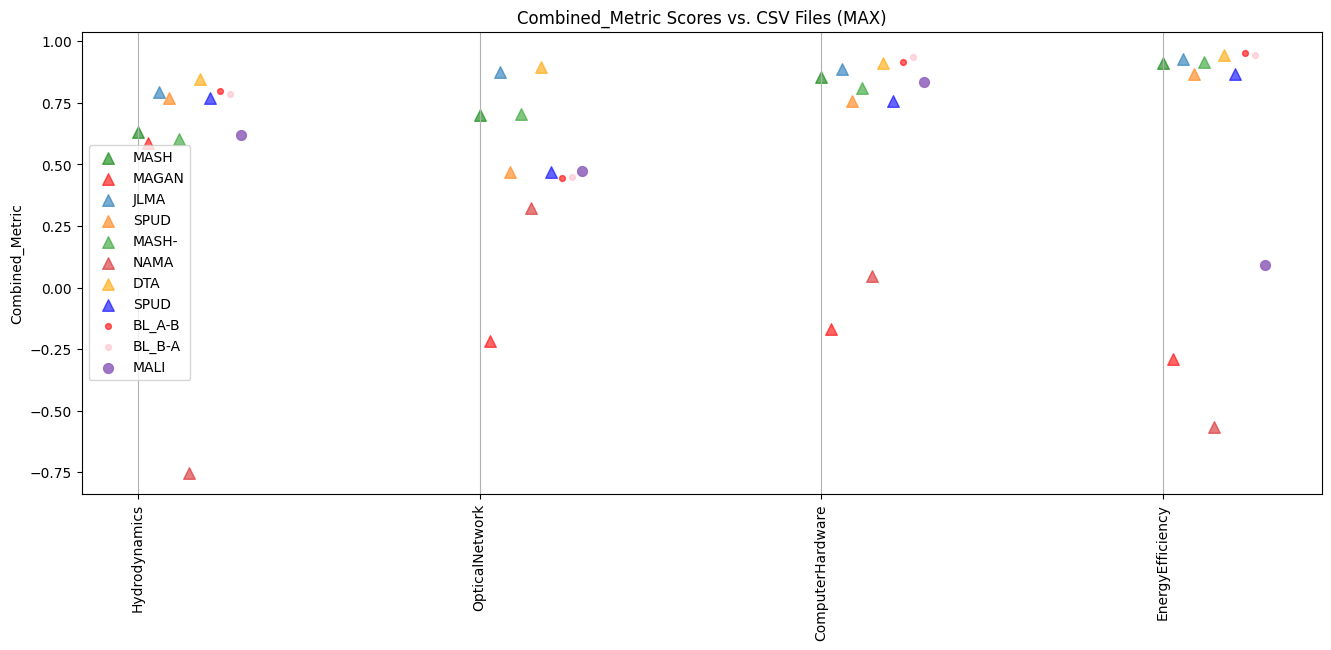

In [8]:
plt_methods_by_CSV_max(df = proc_reg_df, plot_methods=["MASH", "NAMA", "MALI", "SPUD", "MASH-", "BL_A-B", "BL_B-A", "MAGAN", "JLMA", "DTA"])

In [9]:
df =plt_methods_by_CSV_max(df = proc_reg_df, plot_methods=["MASH", "NAMA", "SPUD", "MASH-", "BL_A-B", "BL_B-A", "MAGAN", "JLMA", "DTA"], return_df=True)

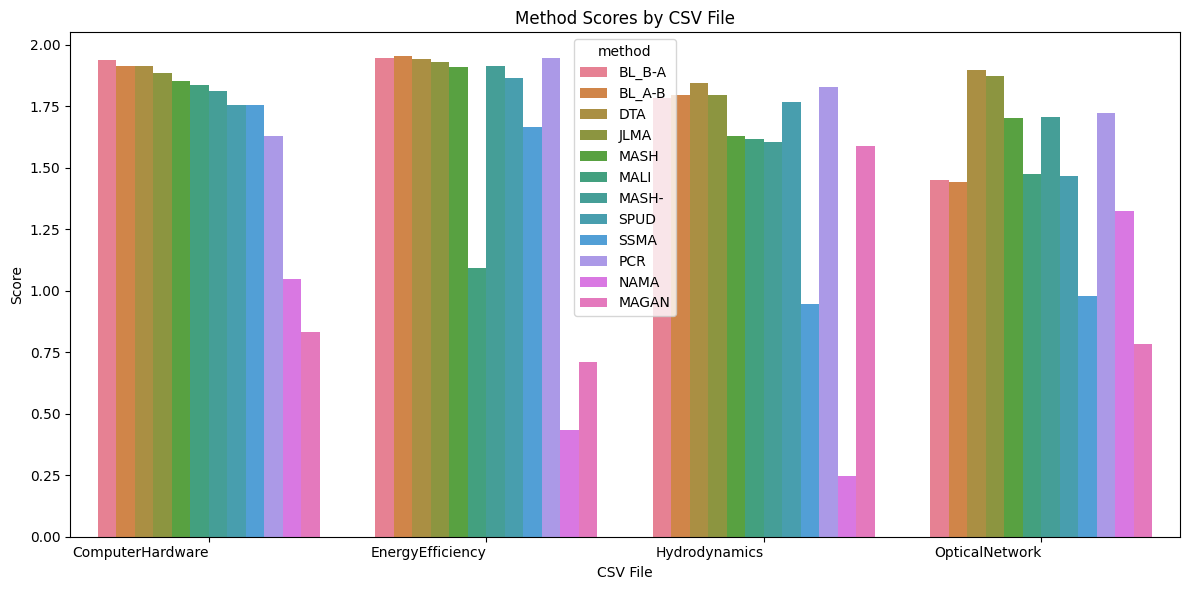

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Step 1: Melt the DataFrame into a long format
df_melted = pd.melt(df, id_vars='csv_file', var_name='method', value_name='score')

# Step 2: Drop rows with NaN values in the 'score' column
df_melted = df_melted.dropna(subset=['score'])

# Step 3: Sort by csv_file and score, with highest score first
df_sorted = df_melted.sort_values(['csv_file', 'score'], ascending=[True, False])

#Lets avoid negative values
df_sorted["score"] = df_sorted["score"] + 1

# Step 4: Plot using seaborn or matplotlib
plt.figure(figsize=(12, 6))
sns.barplot(x='csv_file', y='score', hue='method', data=df_sorted)

# Step 5: Adjust the plot aesthetics
plt.title('Method Scores by CSV File')
plt.xticks(rotation=0, ha='right')  # Rotate x-axis labels for readability
plt.ylabel('Score')
plt.xlabel('CSV File')
plt.tight_layout()

# Show the plot
plt.show()


# Veiw Feature variance

In [11]:
reg_df = read_json_files_to_dataframe("/yunity/arusty/Graph-Manifold-Alignment/RegressionData")

#Average out the random seeds
reg_df["CE"] = [np.mean(list(d.values())) for d in reg_df["CE"].values]
reg_df["FOSCTTM"] = [np.mean(list(d.values())) for d in reg_df["FOSCTTM"].values]
reg_df["Combined_Metric"] = reg_df["CE"] - reg_df["FOSCTTM"]
reg_df.sample(2)

,method,csv_file,split,Percent_of_Anchors,Best_Params,CE,FOSCTTM,Parameter STD,Combined_Metric
4,SPUD,ComputerHardware,distort,0.3,"{'knn': 2, 'OD_method': 'default', 'agg_method...",0.075083,0.036744,"{'knn': 0.3673663152522629, 'OD_method': 0.107...",0.038339
33,MASH-,EnergyEfficiency,distort,0.3,"{'knn': 18, 'page_rank': 'off-diagonal', 'DTM'...",0.916904,0.001598,"{'knn': 0.06169935276836384, 'page_rank': 0.00...",0.915307


### Spud Parameters on STD

In [12]:
spud_param_df = pd.DataFrame(list(reg_df[reg_df["method"] == "SPUD"]["Parameter STD"].values))
spud_param_df

,knn,overide_method,OD_method,agg_method
0,0.370663,0.047433,0.007608,0.040610
1,0.367366,NaN,0.107507,0.021283
2,0.254217,NaN,0.009339,0.519952
3,0.370663,NaN,0.007608,0.040610
4,0.488921,0.511057,0.022239,0.099535
5,0.204033,NaN,0.005697,0.328448
6,0.197790,0.028011,0.052484,0.041140
7,0.564909,NaN,0.028579,0.124819
8,0.258669,NaN,0.009660,0.059614
9,0.204033,0.235853,0.005697,0.328448


<Axes: >

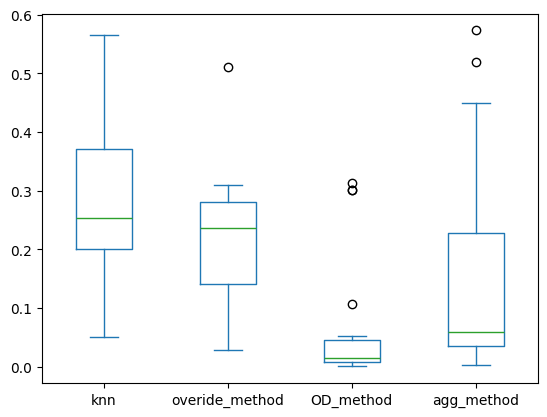

In [13]:
spud_param_df.plot(kind = "box") #This is showing how the std fluctuates between datasets

## MASH Parameters on STD

In [14]:
mash_minus_param_df = pd.DataFrame(list(reg_df[reg_df["method"] == "MASH-"]["Parameter STD"].values))
mash_minus_param_df

,knn,page_rank,DTM,density_normalization
0,0.063462,0.009762,0.077408,0.0
1,0.241471,0.006065,0.067738,0.0
2,0.061699,0.004826,0.055427,0.0
3,0.225188,0.032857,0.050705,0.0


<Axes: >

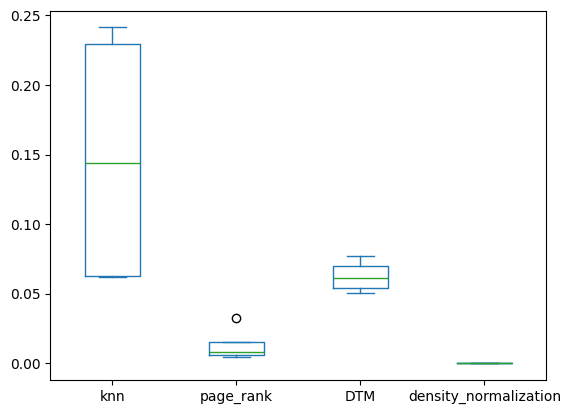

In [15]:
mash_minus_param_df.plot(kind = "box") #This is showing how the std fluctuates between datasets

In [16]:
mash_param_df = pd.DataFrame(list(reg_df[reg_df["method"] == "MASH"]["Parameter STD"].values))
mash_param_df

,connection_limit,threshold,epochs
0,0.034223,0.022946,1.110223e-16
1,0.000000,0.000000,0.000000e+00
2,0.000000,0.000000,0.000000e+00
3,0.093738,0.004785,0.000000e+00


<Axes: >

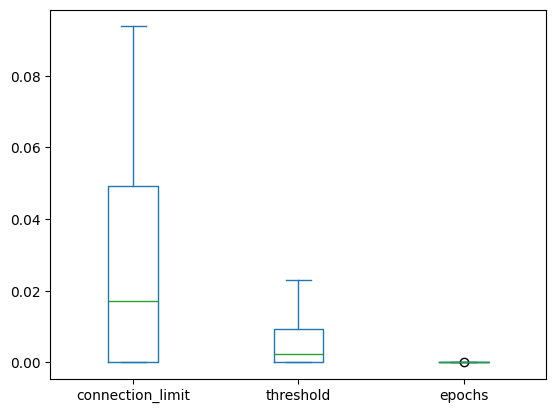

In [17]:
mash_param_df.plot(kind = "box") 